# Analysis of attrition

https://www.kaggle.io/svf/441884/647b8c07ae7a081c547af6d9324351c1/__results__.html#

## Import libraries

In [1]:
import zipfile
import os
import random
import collections

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection
from sklearn import cross_validation
from sklearn import preprocessing
from sklearn import svm
from sklearn import linear_model
from sklearn import tree
from sklearn import ensemble # RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn.feature_selection import SelectFromModel
%matplotlib inline

/Users/yingjiang/miniconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
import sklearn
sklearn.__version__

'0.18.1'

## User defined functions

In [3]:
def performCV(X_train, Y_train, cv, model):
    Y_pred = []
    Y_true = []
    for trainIdx, cvIdx in cv:
        Y_pred.append(model.fit(X_train.iloc[trainIdx], Y_train.iloc[trainIdx]).predict_proba(X_train.iloc[cvIdx]))
        Y_true.append(Y_train.iloc[cvIdx])
    return Y_pred, Y_true
        
def unpackCVResults(Y_pred, Y_true):
    Y_pred_unpack = []
    Y_true_unpack = []
    for yp, yt in zip(Y_pred, Y_true):
        Y_pred_unpack.append([pred_val.argmax() for pred_val in yp])
        Y_true_unpack.append(list(yt.values))
    return Y_pred_unpack, Y_true_unpack

def getCVScores(Y_pred_unpack, Y_true_unpack):
    cvScore_Acc = []
    cvScore_Sens = []
    cvScore_Spec = []
    cvScore_Prec = []
    for yp, yt in zip(Y_pred_unpack, Y_true_unpack):
        cm = metrics.confusion_matrix(y_true = yt, y_pred = yp, labels=None)
        accuracy, sensitivity, specificity, precision = evalModel(cm)
        ## Alternative way of calculating accuracy instead of through cm:
        # match = [i for i, j in zip(Y_pred0, Y_true0) if i == j]
        # len(match) / float(len(Y_pred0))
        cvScore_Acc.append(accuracy)
        cvScore_Sens.append(sensitivity)
        cvScore_Spec.append(specificity)
        cvScore_Prec.append(precision)
    cvScore = pd.DataFrame({
            'accuracy': cvScore_Acc,
            'sensitivity': cvScore_Sens,
            'specificity': cvScore_Spec,
            'precision': cvScore_Prec,
            'recall': cvScore_Sens
        })
    return cvScore

def evalModel(cm):
    TN = cm[0][0]
    FP = cm[0][1]
    FN = cm[1][0]
    TP = cm[1][1]
    P = FN + TP
    N = TN + FP
    Acc = (TN + TP) / float(P + N)
    sensitivity = TP / float(P)
    specificity = TN / float(N)
    precision = TP / float(TP+FP)
    NPV = TN / float(TN+FN)
    FPR = FP / float(FP+TN)
    FDR = FP / float(FP+TP)
    F1 = 2*TP / float(2*TP + FP + FN)
    return Acc, sensitivity, specificity, precision



## Load data

In [4]:
zip_ref = zipfile.ZipFile('human-resources-analytics.zip', 'r')
zip_ref.extractall()
zip_ref.close()

In [5]:
os.listdir(os.getcwd())

['.git',
 '.ipynb_checkpoints',
 'Attrition.ipynb',
 'HR_comma_sep.csv',
 'human-resources-analytics.zip']

In [6]:
HRdata = pd.read_csv('HR_comma_sep.csv', error_bad_lines=False)

In [7]:
HRdata.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


## Explore data

In [8]:
HRdata.sales.unique()

array(['sales', 'accounting', 'hr', 'technical', 'support', 'management',
       'IT', 'product_mng', 'marketing', 'RandD'], dtype=object)

In [9]:
HRdata.corr()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
satisfaction_level,1.000000,0.105021,-0.142970,-0.020048,-0.100866,0.058697,-0.388375,0.025605
last_evaluation,0.105021,1.000000,0.349333,0.339742,0.131591,-0.007104,0.006567,-0.008684
number_project,-0.142970,0.349333,1.000000,0.417211,0.196786,-0.004741,0.023787,-0.006064
average_montly_hours,-0.020048,0.339742,0.417211,1.000000,0.127755,-0.010143,0.071287,-0.003544
time_spend_company,-0.100866,0.131591,0.196786,0.127755,1.000000,0.002120,0.144822,0.067433
Work_accident,0.058697,-0.007104,-0.004741,-0.010143,0.002120,1.000000,-0.154622,0.039245
left,-0.388375,0.006567,0.023787,0.071287,0.144822,-0.154622,1.000000,-0.061788
promotion_last_5years,0.025605,-0.008684,-0.006064,-0.003544,0.067433,0.039245,-0.061788,1.000000


On first inspection, attrition is most correlated to satisfaction level, time spent in company.
Slightly correlated to monthly hours, number of projects and promotion.
Moderately correlated to work accident occurrence, but this attrition mechanism could be different.

In [10]:
HRdata[['salesCat', 'salaryCat']] = HRdata[['sales', 'salary']].apply(preprocessing.LabelEncoder().fit_transform)

In [11]:
HRdata.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary,salesCat,salaryCat
0,0.38,0.53,2,157,3,0,1,0,sales,low,7,1
1,0.80,0.86,5,262,6,0,1,0,sales,medium,7,2
2,0.11,0.88,7,272,4,0,1,0,sales,medium,7,2
3,0.72,0.87,5,223,5,0,1,0,sales,low,7,1
4,0.37,0.52,2,159,3,0,1,0,sales,low,7,1


In [12]:
HRdata.columns

Index([u'satisfaction_level', u'last_evaluation', u'number_project',
       u'average_montly_hours', u'time_spend_company', u'Work_accident',
       u'left', u'promotion_last_5years', u'sales', u'salary', u'salesCat',
       u'salaryCat'],
      dtype='object')

In [13]:
HRdata = HRdata[[u'satisfaction_level', u'last_evaluation', u'number_project', u'average_montly_hours',
                 u'time_spend_company', u'Work_accident', u'promotion_last_5years', u'salesCat', u'salaryCat', u'sales', u'salary', u'left']]

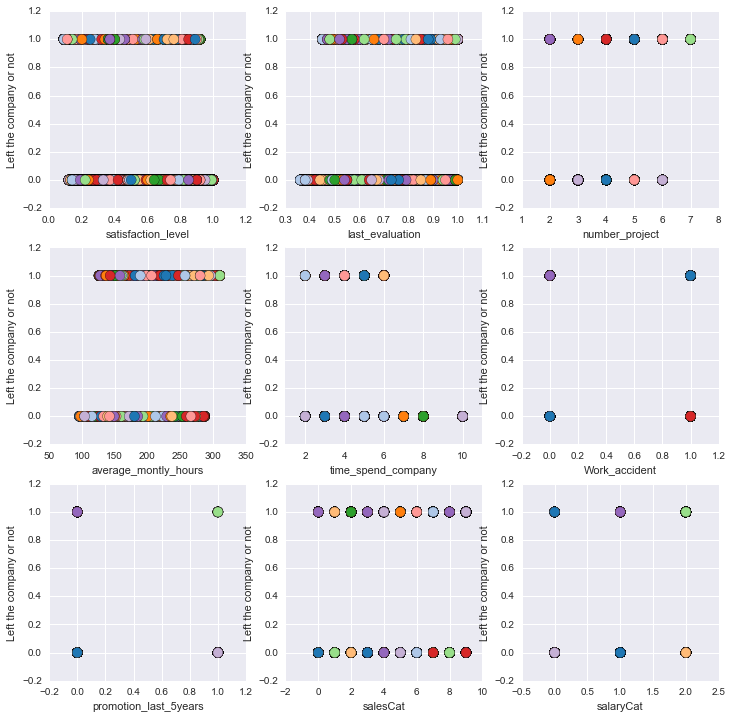

In [14]:
plt.figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')

tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]
for i in range(len(tableau20)):    
    r, g, b = tableau20[i]    
    tableau20[i] = (r / 255., g / 255., b / 255.)    

y = HRdata.left

for i, j in zip([u'satisfaction_level', u'last_evaluation', u'number_project', u'average_montly_hours',
                 u'time_spend_company', u'Work_accident', u'promotion_last_5years', u'salesCat', u'salaryCat'], range(9)):
    x = HRdata[i]

    plt.subplot(int('33'+ str(j+1)))
#     n, bins, patches = plt.hist(functionGroup.satisfaction_level, bins=np.arange(0, 10+0.1, 0.1), normed = None, facecolor = 'green', alpha = 0.5)
#     y = mlab.normpdf(bins, functionGroup.satisfaction_level.mean(), functionGroup.satisfaction_level.std())
#     l = plt.plot(bins, y, 'r--', linewidth = 1)
    plt.scatter(x, y, marker='o', s=100, label=HRdata.sales, c = tableau20[:10])
    plt.xlabel(str(i))
    plt.ylabel('Left the company or not')
#     plt.title('Histogram of x coordinates')
#     plt.axis([functionGroup.satisfaction_level.mean() - functionGroup.satisfaction_level.std(),
#               functionGroup.satisfaction_level.mean() + functionGroup.satisfaction_level.std(), 0, 8])
#     plt.axis([0, 50, 0, n.max()])

    plt.grid(True)
plt.show()

The above told us that relatively stronger predictors of attrition might consist of:
- satisfaction level
- performance (as evaluated in the last round of appraisal)
- number of projects
- average monthly hours
- time spent in company

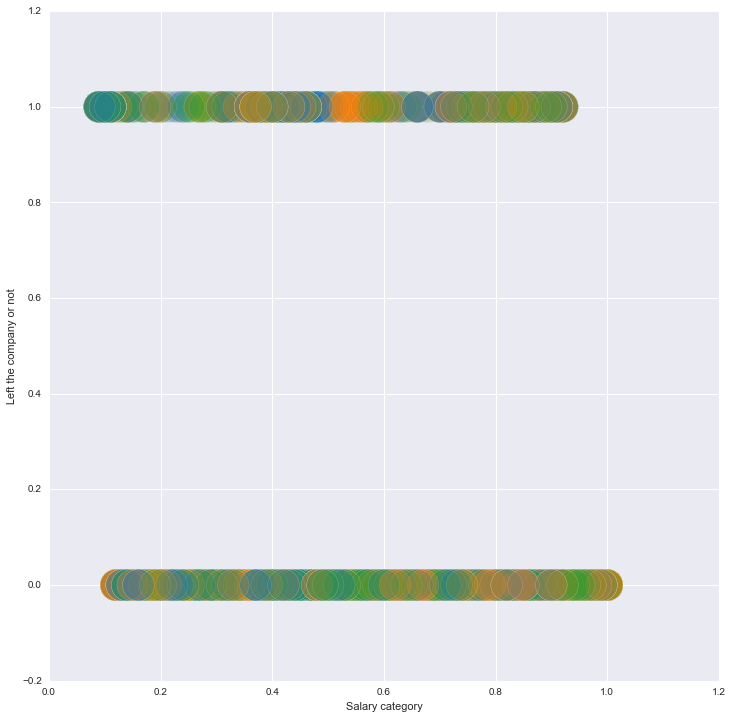

In [15]:
plt.figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='w')

tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]
for i in range(len(tableau20)):    
    r, g, b = tableau20[i]    
    tableau20[i] = (r / 255., g / 255., b / 255.)    

y = HRdata.left

# [u'satisfaction_level', u'last_evaluation', u'number_project', u'average_montly_hours',
# u'time_spend_company', u'Work_accident', u'promotion_last_5years', u'salesCat', u'salaryCat']
x = HRdata['satisfaction_level']
plt.scatter(x, y, marker='o', s=1000, label=HRdata.salary, c = [tableau20[0], tableau20[2], tableau20[4]], edgecolor = 'w', alpha = 0.2)
plt.xlabel('Salary category')
plt.ylabel('Left the company or not')

plt.grid(True)
plt.show()

## Build models to predict attrition

### 1. Make training and testing data

In [16]:
Y = HRdata.left
X = HRdata.drop(['sales', 'salary', 'left'], axis = 1)
X_train, X_test, Y_train, Y_test = cross_validation.train_test_split(X, Y, test_size=0.2, random_state=42)

print X_train.shape
print X_test.shape
print Y_train.shape
print Y_test.shape


(11999, 9)
(3000, 9)
(11999,)
(3000,)


### 2. Set up model and cross-validation

In [17]:
# models = {
#     'SVM': svm.SVC(degree=0.5),
#     'linearSVC': svm.LinearSVC(C=0.01, penalty='l1', dual=False),
#     'naive Bayes': GaussianNB(),
#     'random forest': ensemble.RandomForestClassifier(n_estimators=100),
#     'logistic regression': linear_model.LogisticRegression(),
#     'decision tree': tree.DecisionTreeClassifier()
# }

cv10 = cross_validation.KFold(n=X_train.shape[0], n_folds=10)

key_value_pairs = [('naive Bayes', GaussianNB()),
                   ('logistic regression', linear_model.LogisticRegression()),
                   ('SVM', svm.SVC(degree=0.5)),
                   ('linearSVC', svm.LinearSVC(C=0.01, penalty='l1', dual=False)),
                   ('decision tree', tree.DecisionTreeClassifier()),
                   ('random forest', ensemble.RandomForestClassifier(n_estimators=100))
                  ]
models = collections.OrderedDict(key_value_pairs)

In [18]:
for i in models.values():
    print i

GaussianNB(priors=None)
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=0.5, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
LinearSVC(C=0.01, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l1', random_state=None, tol=0.0001,
     verbose=0)
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort

#### Plan:
1. Use one of the models, e.g. random forest first.
2. Tune parameters on the model e.g. reg parameter for the logistic regression model. Do a grid search if necessary.
3. 

### 3. Perform cross-validation.

In [19]:
model = models.get('random forest') # RF
Y_pred, Y_true = performCV(X_train, Y_train, cv=cv10, model = model)
Y_pred_unpack, Y_true_unpack = unpackCVResults(Y_pred, Y_true)
cvScore = getCVScores(Y_pred_unpack, Y_true_unpack)

cvScore


,accuracy,precision,recall,sensitivity,specificity
0,0.990833,0.996491,0.965986,0.965986,0.998896
1,0.991667,1.000000,0.962687,0.962687,1.000000
2,0.990000,0.996466,0.962457,0.962457,0.998897
3,0.990833,1.000000,0.959410,0.959410,1.000000
4,0.989167,0.996491,0.959459,0.959459,0.998894
5,0.989167,0.989796,0.966777,0.966777,0.996663
6,0.995000,0.996296,0.981752,0.981752,0.998920
7,0.993333,1.000000,0.973244,0.973244,1.000000
8,0.992500,1.000000,0.970297,0.970297,1.000000
9,0.994162,0.992395,0.981203,0.981203,0.997856


In [20]:
print 'Model: ', model
print 'Mean CV accuracy: ', cvScore.accuracy.mean()
print 'Mean CV precision: ', cvScore.precision.mean()
print 'Mean CV recall: ', cvScore.recall.mean()

Model:  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
Mean CV accuracy:  0.99166618015
Mean CV precision:  0.996793653916
Mean CV recall:  0.9683272771


### 4. Apply on unseen (test) data

In [21]:
Y_test_pred = model.fit(X_train, Y_train).predict_proba(X_test)
Y_test_pred_unpack = [pred_val.argmax() for pred_val in Y_test_pred]

cm_test = metrics.confusion_matrix(y_true = Y_test, y_pred = Y_test_pred_unpack, labels=None)
accuracy, sensitivity, specificity, precision = evalModel(cm_test)
print 'Model: ', model
print 'Testing accuracy: ', accuracy
print 'Testing precision: ', precision
print 'Testing recall: ', sensitivity

Model:  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
Testing accuracy:  0.989
Testing precision:  0.98981077147
Testing recall:  0.963172804533


## Feature importance

### Get feature ranking after fitting the RF model

In [22]:
model = models.get('random forest') # RF
Y_test_pred_featImp = model.fit(X_train, Y_train)

importances = model.feature_importances_
std = np.std([indivTree.feature_importances_ for indivTree in model.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]


In [23]:
print X_train.columns
print importances
print indices

Index([u'satisfaction_level', u'last_evaluation', u'number_project',
       u'average_montly_hours', u'time_spend_company', u'Work_accident',
       u'promotion_last_5years', u'salesCat', u'salaryCat'],
      dtype='object')
[ 0.33004149  0.11929448  0.18942487  0.15292552  0.1803053   0.00604286
  0.0009842   0.01224269  0.0087386 ]
[0 2 4 3 1 7 8 5 6]


In [24]:
len(model.estimators_) # We have a default of 100 trees in this Random Forest.

100

In [25]:
for indivTree in model.estimators_[:10]:
    print indivTree.feature_importances_.argmax() # index of the feature with the highest importance
    print indivTree.feature_importances_.argmin() # index of the feature with the lowest importance
    print ''

3
6

0
6

0
6

0
6

2
6

0
6

0
6

0
6

0
6

0
5



In [26]:
# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. %s (%f)" % (f + 1, X_train.columns[indices[f]], importances[indices[f]]))

Feature ranking:
1. satisfaction_level (0.330041)
2. number_project (0.189425)
3. time_spend_company (0.180305)
4. average_montly_hours (0.152926)
5. last_evaluation (0.119294)
6. salesCat (0.012243)
7. salaryCat (0.008739)
8. Work_accident (0.006043)
9. promotion_last_5years (0.000984)


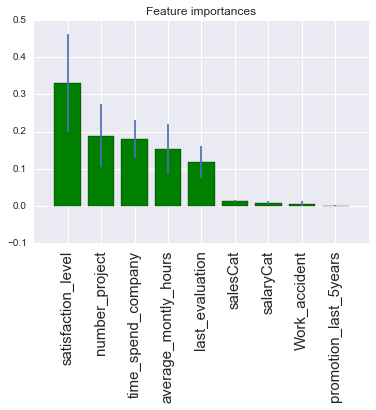

In [27]:
# Plot the feature importances of the forest
fig, ax = plt.subplots()
# plt.figure() # If this line is included, an empty plot appears.
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="g", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices, rotation=90)
plt.xlim([-1, X_train.shape[1]])
ax.set_xticklabels(X_train.columns[indices], rotation=90, size=15)
plt.show() # If this line is not included, a bunch of msgs appear

### Get feature ranking after fitting an SVM model

In [28]:
model = models.get('linearSVC')
lsvc = model.fit(X_train, Y_train)
model_SelectFeat = SelectFromModel(lsvc, prefit=True)
X_new = model_SelectFeat.transform(X_train)

# importances = model.feature_importances_
# std = np.std([tree.feature_importances_ for tree in model.estimators_],
#              axis=0)
# indices = np.argsort(importances)[::-1]



In [29]:
print X_new.shape

(11999, 7)


In [30]:
print model_SelectFeat.get_support()
print model_SelectFeat.get_support(indices=True)
print X_train.columns[model_SelectFeat.get_support(indices=True)]

[ True False  True  True  True  True  True  True False]
[0 2 3 4 5 6 7]
Index([u'satisfaction_level', u'number_project', u'average_montly_hours',
       u'time_spend_company', u'Work_accident', u'promotion_last_5years',
       u'salesCat'],
      dtype='object')


The above are features selected by linearSVC (L1 regularization).
Compare with RF features ranked by Gini importance:

In [31]:
# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. %s (%f)" % (f + 1, X_train.columns[indices[f]], importances[indices[f]]))

Feature ranking:
1. satisfaction_level (0.330041)
2. number_project (0.189425)
3. time_spend_company (0.180305)
4. average_montly_hours (0.152926)
5. last_evaluation (0.119294)
6. salesCat (0.012243)
7. salaryCat (0.008739)
8. Work_accident (0.006043)
9. promotion_last_5years (0.000984)


- The top features are more or less the same.
- The two least important features from RF are selected by linearSVC/L1.
- The feature 'last evaluation', deemed moderately important by RF, is not selected by linearSVC/L1.

## Plot an ROC curve

### Using decision_function()

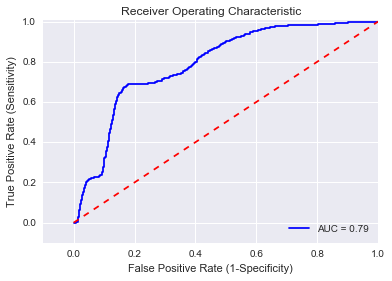

[ 1.70652257  0.70652257  0.34551078  0.34538524  0.34460487  0.32218542
  0.31616488  0.30727413  0.30612924  0.30168706]


In [32]:
model = models.values()[3] # LR
Y_test_pred_roc = model.fit(X_train, Y_train).decision_function(X_test)

fpr, tpr, thresholds = metrics.roc_curve(Y_test,Y_test_pred_roc)
roc_auc = metrics.auc(fpr,tpr)

# Plot ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate (Sensitivity)')
plt.xlabel('False Positive Rate (1-Specificity)')
plt.show()

print thresholds[:10]

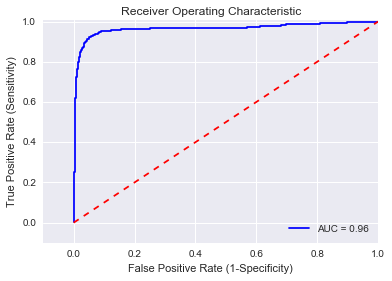

In [34]:
model = models.get('SVM')
Y_test_pred_roc = model.fit(X_train, Y_train).decision_function(X_test)

fpr, tpr, thresholds = metrics.roc_curve(Y_test,Y_test_pred_roc)
roc_auc = metrics.auc(fpr,tpr)

# Plot ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate (Sensitivity)')
plt.xlabel('False Positive Rate (1-Specificity)')
plt.show()

### Using RF's predict_proba()

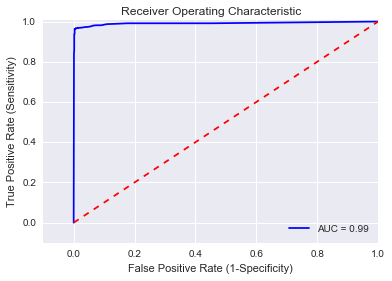

In [35]:
model = models.get('random forest')
Y_test_pred_roc = model.fit(X_train, Y_train).predict_proba(X_test)[:, 1]
# y_pred_rf_lm = rf_lm.predict_proba(rf_enc.transform(rf.apply(X_test)))[:, 1]
fpr, tpr, thresholds = metrics.roc_curve(Y_test,Y_test_pred_roc)
roc_auc = metrics.auc(fpr,tpr)
# fpr_rf_lm, tpr_rf_lm, _ = roc_curve(y_test, y_pred_rf_lm)

# Plot ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate (Sensitivity)')
plt.xlabel('False Positive Rate (1-Specificity)')
plt.show()

**Interpreting thresholds**

In [ ]:
thresholds = [0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9, 0.95]

model = models.values()[3]
Y_test_pred_roc = model.fit(X_train, Y_train).predict_proba(X_test)

plt.figure(figsize=(10,10))

j = 1
for i in thresholds:
    Y_test_pred_roc_Class1 = Y_test_pred_roc[:,1] > i
    
    plt.subplot(3,3,j)
    j += 1
    
    cm = metrics.confusion_matrix(Y_test,Y_test_pred_roc_Class1)
    np.set_printoptions(precision=2)
    accuracy, sensitivity, specificity, precision = evalModel(cm)
    print "Threshold: ", i
    print "True positive rate (Sensitivity) in the testing dataset: ", sensitivity
    print "False positive rate (1-specificity)  in the testing dataset: ", 1-specificity
    print ''

## Tune model parameters through gridsearch

### Regular grid search

In [ ]:
model = models.values()[3] # 

parameters = {'penalty':('l1', 'l2'),
              'C':[0.01, 0.1, 1, 10]}

model = model_selection.GridSearchCV(estimator = model,
                                     param_grid = parameters,
                                     cv = 5)
Y_test_gs = model.fit(X_train, Y_train)

# cm_test = metrics.confusion_matrix(y_true = Y_test, y_pred = Y_test_pred_unpack, labels=None)
# accuracy, sensitivity, specificity, precision = evalModel(cm_test)
# print 'Model: ', model
# print 'Testing accuracy: ', accuracy
# print 'Testing precision: ', precision
# print 'Testing recall: ', sensitivity

In [ ]:
print Y_test_gs.best_params_

In [ ]:
print Y_test_gs.cv_results_['params']
print Y_test_gs.cv_results_['mean_test_score']
print Y_test_gs.cv_results_['std_test_score']

### Grid search with "recall" as metric

In [ ]:
model = models.values()[3] # 

parameters = {'penalty':('l1', 'l2'),
              'C':[0.01, 0.1, 1, 10]}

model = model_selection.GridSearchCV(estimator = model,
                                     param_grid = parameters,
                                     cv = 5,
                                     scoring = 'recall')
Y_test_gs = model.fit(X_train, Y_train)

In [ ]:
print Y_test_gs.best_params_
print Y_test_gs.cv_results_['params']
print Y_test_gs.cv_results_['mean_test_score']
print Y_test_gs.cv_results_['std_test_score']

### String value for the "scoring" parameter
The "scoring" parameter seems to take in a bunch of different strings, e.g.
1. 'recall'
2. 'recall_score' ?
3. 'recall_macro' ?
4. 'recall_micro'... ?

By throwing an error, we finally learn what kind of values "scoring" accepts.

In [ ]:
model = models.values()[3] # 

parameters = {'penalty':('l1', 'l2'),
              'C':[0.01, 0.1, 1, 10]}

model = model_selection.GridSearchCV(estimator = model,
                                     param_grid = parameters,
                                     cv = 5,
                                     scoring = 'recall_score')
Y_test_gs = model.fit(X_train, Y_train)

## An investigation of the predict_proba() and decision_function() functions

After fitting an sklearn model, there are three options:
1. Predict outright with cv / unseen data.
2. Predict the probability
3. Apply a decision function.

Note that a decision function in SVM outputs the distance from the decision boundary.

In [ ]:
# Using logistic regression as the model (rf doesn't have decision_function())
model_tmp = models.values()[3]

# Create training and cv data:
X_trtmp = X_train.iloc[list(cv10)[0][0]]
Y_trtmp = Y_train.iloc[list(cv10)[0][0]]
X_cvtmp = X_train.iloc[list(cv10)[0][1]]
Y_cvtmp = Y_train.iloc[list(cv10)[0][1]]

# After fitting the model, go through each of the three styles of prediction
predtmp1 = model_tmp.fit(X_trtmp, Y_trtmp).predict(X_cvtmp)
predtmp2 = model_tmp.fit(X_trtmp, Y_trtmp).predict_proba(X_cvtmp)
predtmp3 = model_tmp.fit(X_trtmp, Y_trtmp).decision_function(X_cvtmp)

# Verify the relationship between these three styles of prediction
Y_predtmp1 = predtmp1
Y_predtmp2 = [yp.argmax() for yp in predtmp2]
Y_predtmp3 = [0 if yp<0 else 1 for yp in predtmp3]



In [ ]:
print predtmp1
print predtmp2
print predtmp3

#### predict_proba() outputs the following:
- [[sample1_class1_proba, sample1_class2_proba], [sample2_class1_proba, sample2_class2_proba], [sample3_class1_proba, sample3_class2_proba] ...]

#### decision_function() outputs the following:
- for each sample, a number that is >0 if class1 and <0 if class0

In [ ]:
print len(Y_predtmp1)
print sum(Y_predtmp1 == Y_predtmp2)
print sum(Y_predtmp1 == Y_predtmp3)


After converting predict_proba() and decision_function() outputs to, essentially, predict() outputs, one can see it's all the same.